In [1]:
#zhangjianming audio classification via 3 features 2019-12-16

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from fastai.vision import *
from fastai.vision.models.wrn import wrn_22
from fastai.vision.models import *

from torchvision.models import *
import pretrainedmodels
from efficientnet_pytorch import EfficientNet
SEED = 2019
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = datapath4file('/data/zhangjianming/kaggle/sound/data/melspec/')
#path = datapath4file('/data/zhangjianming/kaggle/sound/data/mfccs/')
#path = datapath4file('/data/zhangjianming/kaggle/sound/data/chroma/')

3 features 

def get_data(sz,bs):
    tfms = get_transforms(flip_vert=False,max_rotate=10, p_affine =1., p_lighting=1.,
                      max_lighting=0.7, max_zoom=1.5, max_warp=0.1) 
    #tfms = get_transforms()   
    data = ImageDataBunch.from_folder(path, size=sz,train = 'train', valid_pct = 0.2, test = 'test', bs = bs)
    data.normalize(imagenet_stats)
    return data
path.ls()
data = get_data(224,32)
#data.show_batch(row =6,figsize = (15,15))

In [ ]:
data

In [3]:
arch = EfficientNet.from_pretrained('efficientnet-b0',num_classes=data.c)
#arch = EfficientNet.from_pretrained('efficientnet-b3',num_classes=data.c)
#arch = EfficientNet.from_pretrained('efficientnet-b7',num_classes=data.c)
#loss_func = LabelSmoothingCrossEntropy()
learn = Learner(data, arch, metrics = accuracy)
learn = learn.split([learn.model._conv_stem,learn.model._blocks,learn.model._conv_head])
learn.to_fp16()
learn.lr_find()
learn.recorder.plot()

Loaded pretrained weights for efficientnet-b0


Learner(data=ImageDataBunch;

Train: LabelList (1965 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
32,32,32,32,32
Path: /data/zhangjianming/kaggle/sound/data/train_data_new;

Valid: LabelList (1965 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
32,32,32,32,32
Path: /data/zhangjianming/kaggle/sound/data/train_data_new;

Test: LabelList (400 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: /data/zhangjianming/kaggle/sound/data/train_data_new, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_ru

In [ ]:
classes = learn.data.classes
classes

epoch,train_loss,valid_loss,accuracy,time
0,2.800721,1.781202,0.522646,02:13


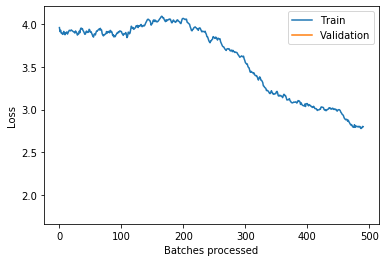

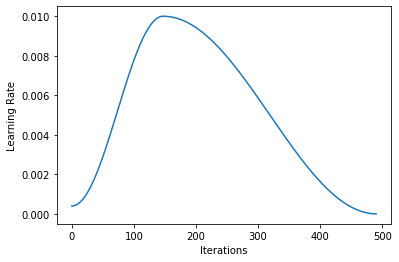

In [4]:
learn.fit_one_cycle(8,(1e-4, 1e-3, 1e-2), wd=0.2)
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=(1e-5,1e-4,1e-3), wd=(1e-4,1e-3,0.2))
learn.recorder .plot_losses() 
learn.recorder.plot_lr()

In [ ]:
learn

In [5]:
learn.to_fp32()
#preds, _ = learn.TTA(ds_type=DatasetType.Test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
classes = learn.data.classes

In [12]:
results  = ['' for x in range(preds.shape[0])]
for i in np.arange(preds.shape[0]):
    #results[i] = preds[i].numpy()
    results[i] = classes[np.argmax(preds[i]).numpy()]
ids = [item.name[:-4] for item in learn.data.test_ds.items]
df = pd.DataFrame({'id':ids, 'label': results})
#df = pd.DataFrame(results, ids,columns=['id','label'])
df.head()

,id,label
0,313,"[0.00071702315, 0.0014694027, 0.007375723, 0.0..."
1,138,"[0.015893998, 0.0019469643, 0.00084006845, 0.0..."
2,256,"[0.0014347282, 0.010931978, 0.001552489, 0.001..."
3,284,"[0.0019938024, 0.0014186712, 0.044285625, 0.03..."
4,230,"[0.00032279466, 0.0019879465, 0.00010182013, 0..."
